# Lab 10 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

## Introduction

The main aim of this lab is to train a Vanilla CNN and Fine-Tune the pre-trained VGG16 base model to classify Dogs and Cats. We will use the Cats vs Dogs Dataset from Kaggle. The original dataset in kaggle consists of 25,000 images for Training. Out of those 25,000 images we are going to use only a small portion of dataset consisting of 3000 images. 2000 images for training, 1000 images for validation and 2000 images for testing. Both the classes Cats and dogs consists of equal number of images during training, validation and testing. The Class of Cats has a label of 0 and Dogs has label 1.

In [1]:
# Importing the libraries
from tensorflow.keras.datasets import fashion_mnist
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import pandas as pd
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, f1_score,classification_report,precision_recall_curve

In [2]:
# Folder path to the dataset
data_folder = pathlib.Path('data\kaggle_dogs_vs_cats_small')

In [3]:
# Loading the images directly from the directory with labels as 0 and 1 in batch size of 32. Also we will resize the image to height and width of 180X180
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [4]:
# Printing the type of the training dataset
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [5]:
# Printing the shape of the input Image Data and corresponding images
for data_batch, labels_batch in train_dataset:
    print("Image data batch shape:", data_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break

Image data batch shape: (32, 180, 180, 3)
Labels batch shape: (32,)


In [13]:
# labels of images in first batch - labels are of type integer 32 bits
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0])>

## Data Exploration
### Visualizing first batch of 32 images in the training dataset

In some images we can see that, there are **two or three dogs/cats** in the same image. Also the images include the surrounding environment, other objects as well as humans. **Each image is 180X180 pixels with three channels RGB**

In [14]:
# Creating a list of label description
label_description = ["Cat","Dog"]

In [15]:
# To plot the images along with labels
def plot_images(image_data,label):
    plt.imshow(image_data.numpy().astype("uint8"))
    plt.title(f"{label}-{label_description[label]}", fontsize=8)
    plt.axis("off")

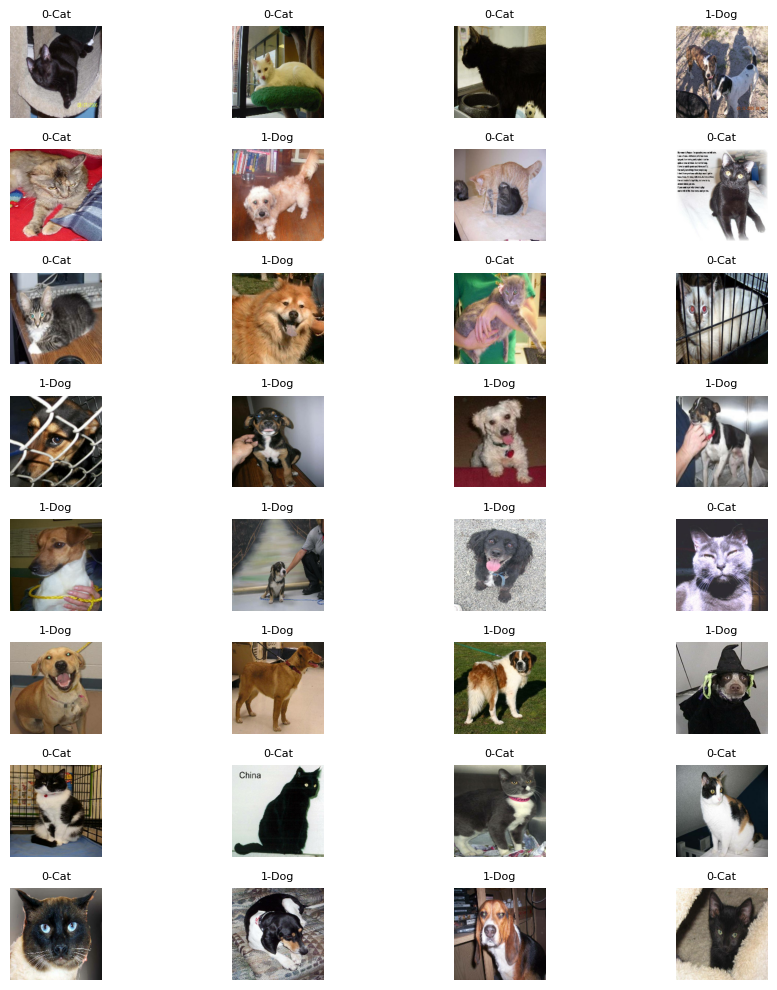

In [16]:
# Displaying the first batch - 32 images along with class description 
plt.figure(figsize=(10, 10))
for idx, image_data in enumerate(data_batch):
    plt.subplot(8, 4, idx + 1)
    plot_images(image_data,labels_batch[idx])
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

## Distribution of pixel values of all images in training set

The below histogram shows **the intensity of pixel values for the three color channels red, blue and green across all images** in the training dataset.

In each channel, the **highest pixel value of 255 denotes the dominance of that particular color channel**. From the plot, we can find that **color channel red has high dominance when compared to green and blue**.

In [56]:
# Initializing empty dictionary to store all the training, validation and testing images along with labels
dataset_labels = {}
dataset_images = {}

In [57]:
# Function to get the total number of images and labels
def getImageCount(dataset,dataset_name):
    label_batches = []
    image_batches = []
    for image_batch, label_batch in dataset:
        label_batches.append(label_batch.numpy())
        image_batches.append(image_batch.numpy().astype("uint8"))
    label_batches = np.concatenate(label_batches)
    image_batches = np.concatenate(image_batches)
    dataset_images[dataset_name] = image_batches
    dataset_labels[dataset_name] = label_batches


In [58]:
getImageCount(train_dataset,"Training")
getImageCount(validation_dataset,"Validation")
getImageCount(test_dataset,"Testing")

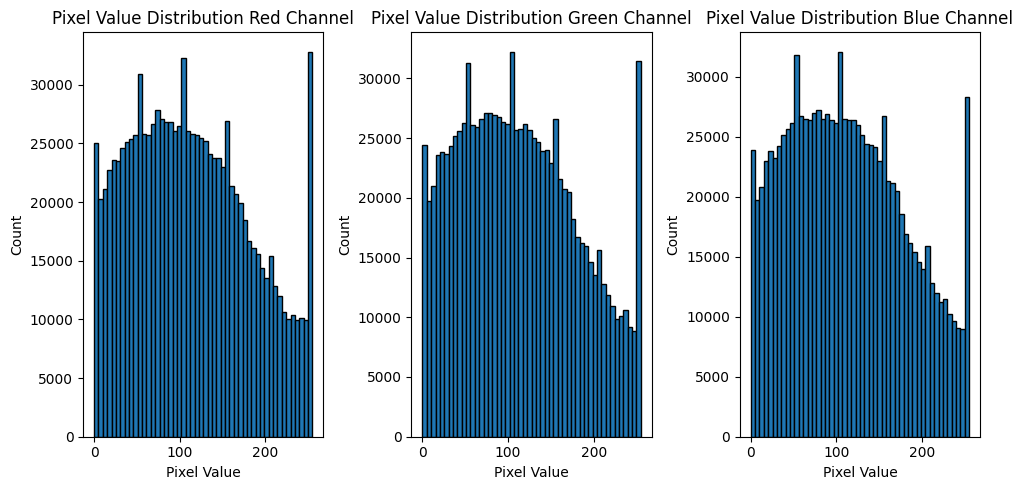

In [66]:
# Plot the distribution of pixel values of all images in training dataset
fig = plt.figure(figsize=(10, 5))
all_training_images = dataset_images['Training']
# subplot the distribution of pixel values in red channel of all images in training dataset
plt.subplot(1, 3, 1)
plt.hist(all_training_images[:,:,0].ravel(),  bins=50,edgecolor='black')
plt.title('Pixel Value Distribution Red Channel')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
# subplot the distribution of pixel values in green channel of all images in training dataset
plt.subplot(1, 3, 2)
plt.hist(all_training_images[:,:,1].ravel(),  bins=50,edgecolor='black')
plt.title('Pixel Value Distribution Green Channel')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
# subplot the distribution of pixel values in blue channel of all images in training dataset
plt.subplot(1, 3, 3)
plt.hist(all_training_images[:,:,2].ravel(),  bins=50,edgecolor='black')
plt.title('Pixel Value Distribution Blue Channel')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [86]:
img = data_batch[0].numpy().shape
label = labels_batch[0]

In [92]:
def visualize_input(channel,color):
    fig = plt.figure(figsize = (12,12)) 
    ax = fig.add_subplot(111)
    img_channel = img[:,:,channel]
    ax.imshow(img[:,:,0])
    ax.set_title(f"{label}-{label_description[label]}")
    width, height = img_channel.shape
    thresh = img_channel.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(img_channel[x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color=color if img_channel[x][y]<thresh else 'black',fontsize ='8')
    ax.set_xticks([])
    ax.set_yticks([])

### Bar plot to show the distribution of images of both classes in training, testing and validation set.

From the graph, it is evident that **there are equal number of images in both the classes**. The **dataset is class balanced with 0 skewness.**

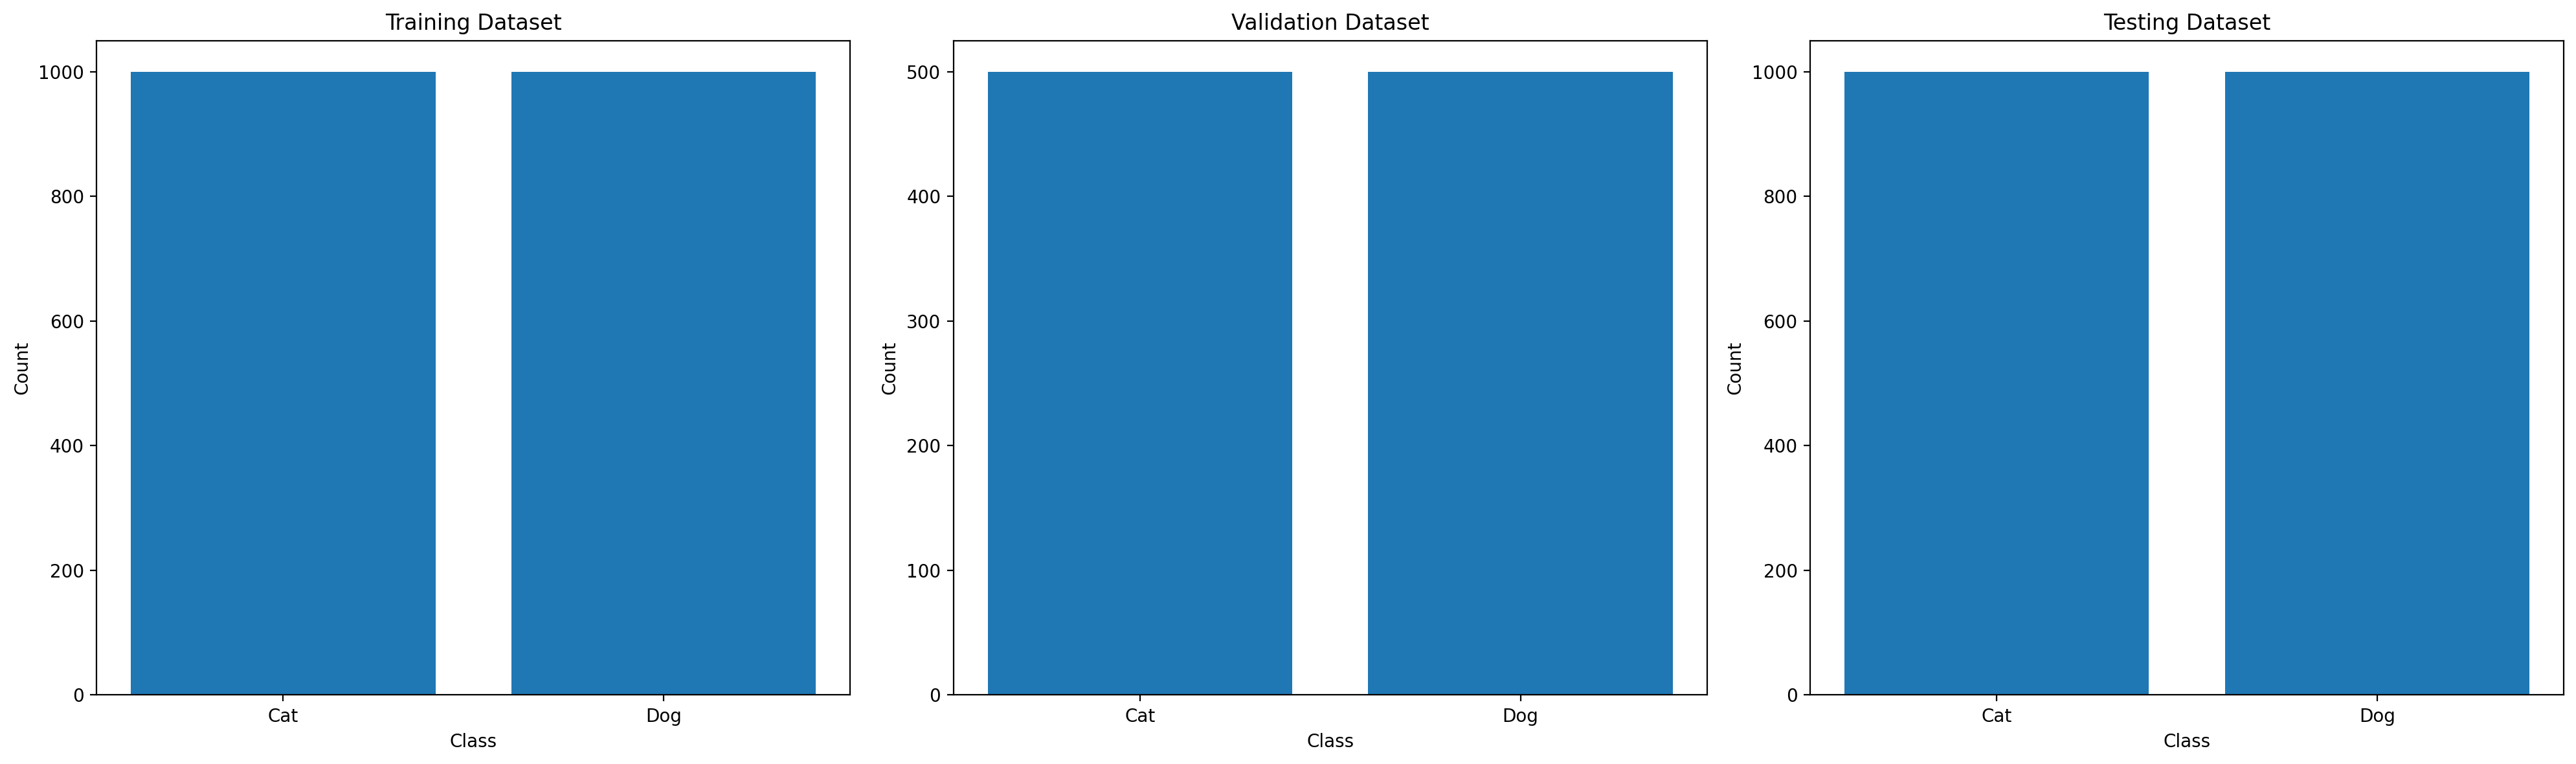

In [67]:
# Count the occurrences of each class in training, validation and testing dataset
plt.figure(figsize=(20, 6),dpi=200)
for index, (dataset_name,data_labels) in enumerate(dataset_labels.items()):
    plt.subplot(1, 3, index+1)
    counts = np.bincount(data_labels)
    plt.bar(label_description, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'{dataset_name} Dataset')
    plt.tight_layout()

## Data Pre-processing

### Data Augmentation

**Data Augmentation** is a **technique used to artificially increase the size of the dataset by applying random transformations to images such as image rotation, zooming etc**. Here we have used **keras pre-processing layers such as RandomFlip, RandomRotation and RandomZoom**.

In [93]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.3),
    ]
)

### Displaying the images after performing Data augmentation

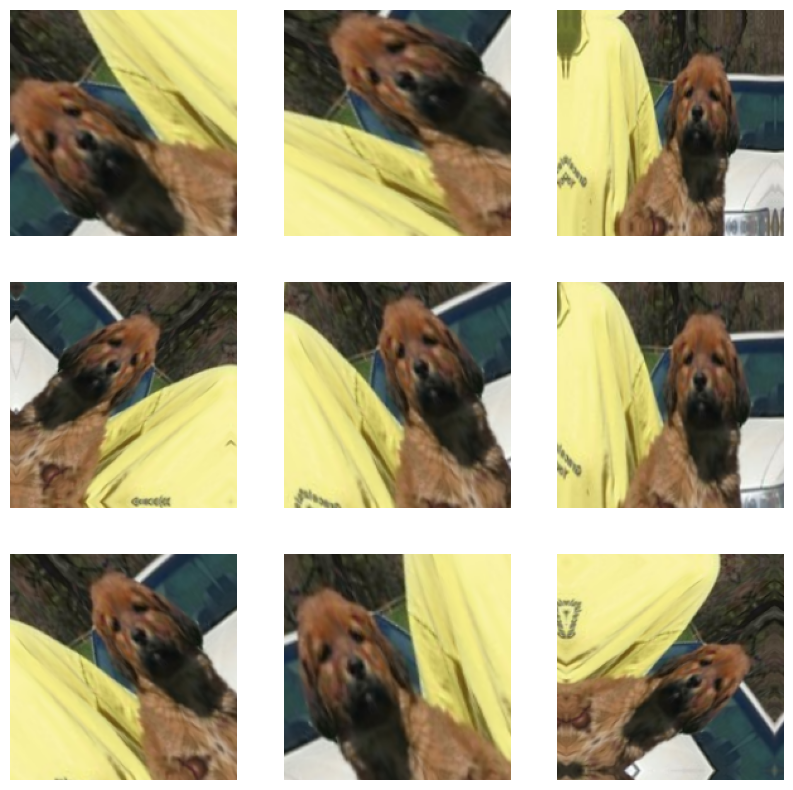

In [95]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Modeling

Here we are going to train two models 
 - Vanilla (Convolutional Neural Network)CNN
 - Fine Tuning VGG-16 pre-trained model

### Specification of Vanilla CNN

1. The **Vanilla CNN** consists of **Input layer, Data Augmentation layer and rescaling layer which scales the pixel values in the range [0-1]**.
2. It consists of **5 convolutional layers**. The **first two convolutional layers** has **kernel size of 3**, **number of filters 32 and 64** respectively.
3. The **other two convolutional** has **kernel size of 5** and **number of filters is 128 and 256 in each layer**.
4. The **last convolutional layer** has a **kernel size of 7** and **there are 512 filters in total**.
5. There are **four MaxPooling layer** each with a **pool size of 2**.
6. There is **one flatten layer** and **one dropout layer**.
7. The **output layer is a dense with one neuron and sigmoid activation function**.
8. The **activation function** used in all these layers except output layer is **Rectified Linear Unit (relu)**. 
9. From the model summary we can find that the **total number of trainable parameters** is **7,467,329**.
10. The **input shape of the image** is **180X180X3**. And the **final output shape after the last dense layer** is **a array with depth 1**.
11. The **dropout layer** is added as a **regularization technique that is used to prevent the model from overfitting the training data**. The **dropout probability** is set as **0.5**.
12. We have used **binary_crossentropy as loss function** since we **have only two classes cats and dogs**. The optimizer used here is **rmsprop**
13. The **number of epochs is 50** with **batch size of 32**. **Total number of training steps is 63**.

In [104]:
# defining the model
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=7, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [105]:
# Model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [106]:
# compiling the model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [107]:
# callback to find the best model and save the model which has less validation loss
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/CNN_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [108]:
# Fitting the model on the training dataset and validating on validation dataset after each epoch
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 90s 1s/step - loss: 0.7052 - accuracy: 0.5010 - val_loss: 0.6928 - val_accuracy: 0.5030
Epoch 2/50
63/63 [==============================] - 85s 1s/step - loss: 0.6942 - accuracy: 0.5005 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 87s 1s/step - loss: 0.6929 - accuracy: 0.5165 - val_loss: 0.6698 - val_accuracy: 0.6230
Epoch 4/50
63/63 [==============================] - 86s 1s/step - loss: 0.6875 - accuracy: 0.5600 - val_loss: 0.6749 - val_accuracy: 0.5570
Epoch 5/50
63/63 [==============================] - 86s 1s/step - loss: 0.6825 - accuracy: 0.5700 - val_loss: 0.6674 - val_accuracy: 0.5700
Epoch 6/50
63/63 [==============================] - 87s 1s/step - loss: 0.6560 - accuracy: 0.6250 - val_loss: 0.6242 - val_accuracy: 0.6660
Epoch 7/50
63/63 [==============================] - 85s 1s/step - loss: 0.6416 - accuracy: 0.6405 - val_loss: 0.6525 - val_accuracy: 0.5990
Epoch 8/50
63/63 [==

### Specification of Pre-trained VGG-16 Network

1. The **base model VGG-16** consists of **16 layers**. **Out of 16 layers** we are going to **freeze the weights of first 12 layers** and will **train only the last 4 layers pf VGG-16 and the top layer**.
2. **Total number of parameters in Pre-trained VGG-16** is **14,714,688**. Since we are **freezing some layers**, **the number of non-trainable parameters** is **7,635,264** and the **number of trainable parameters** is **7,079,424**.
3. We have also **applied data augmentation to the training dataset** by **performing transformations such as RandomFlip,RandomZoom and RandomRotation**.
4. **keras vggnet.preprocess_input** method is **used for preprocessing the input images before feeding them ito VGG-16**. **The pre-trained model VGG-16 expects images in certain format**.  
5. We are **going to use our own top layer instead of the one already present in VGG-16**.
6. The **top layer** consists of **one flatten layer**, **two dense layers each containing 128 neurons** and **one dropout layer**.
7. The output layer is dense layer with sigmoid activation function.
8. The **total number of parameters in the entire network** is **16,369,857**. **Total number of trainable parameters** is **8,734,593**. **Total number of non-trainable parameters** is **7,635,264**.
9. Here **we are using binary cross-entropy as loss function** and **Rmsprop optimizer in keras with learning rate of 0.00001**.

In [120]:
# loading the pre-trained VGG-16 with weights obtained while training imagenet dataset excluding the top layer
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [121]:
# Freezing the weights of first 12 layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [122]:
# summary of pre-trained VGG-16 model
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [125]:
# Defining the top fully connected layer
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
VGG16_Pre_trained_model = keras.Model(inputs, outputs)

In [126]:
# Summary of the customized VGG-16 model
VGG16_Pre_trained_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0   

In [127]:
# Compiling the customized VGG16 pre-trained model
VGG16_Pre_trained_model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [128]:
# callback to find and save the best model which has less validation loss
VGG_16_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/VGG16_fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [129]:
# Fitting the customized VGG-16 model to the training dataset
VGG16_model_history = VGG16_Pre_trained_model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=VGG_16_callbacks)

Epoch 1/50
63/63 [==============================] - 212s 3s/step - loss: 4.4763 - accuracy: 0.6575 - val_loss: 1.0282 - val_accuracy: 0.8520
Epoch 2/50
63/63 [==============================] - 1677s 27s/step - loss: 1.5384 - accuracy: 0.7490 - val_loss: 0.4040 - val_accuracy: 0.9020
Epoch 3/50
63/63 [==============================] - 211s 3s/step - loss: 0.7482 - accuracy: 0.7990 - val_loss: 0.2393 - val_accuracy: 0.9410
Epoch 4/50
63/63 [==============================] - 1989s 32s/step - loss: 0.4533 - accuracy: 0.8560 - val_loss: 0.1615 - val_accuracy: 0.9520
Epoch 5/50
63/63 [==============================] - 4467s 72s/step - loss: 0.3704 - accuracy: 0.8760 - val_loss: 0.1526 - val_accuracy: 0.9580
Epoch 6/50
63/63 [==============================] - 293s 5s/step - loss: 0.3037 - accuracy: 0.8785 - val_loss: 0.1288 - val_accuracy: 0.9610
Epoch 7/50
63/63 [==============================] - 364s 6s/step - loss: 0.2567 - accuracy: 0.8900 - val_loss: 0.1139 - val_accuracy: 0.9640
Epoch 8

## Plotting the Training and validation Loss for Vanilla CNN and Pre-trained VGG-16 models

**Vanilla CNN**

1. From the **training validation loss graph**, **there is a lot of fluctuations in validation loss**.
2. Both **training and validation loss** was **decreaing till epoch 28**. At **epoch 29**, **validation loss increased to 1.1**.
3. After epoch 29, there was huge fluctuations in the validation loss.
4. At epoch 35, the validation loss reache



In [137]:
def plot_training_val_loss(model_history):
    history_dict = model_history.history
    plt.figure(figsize=(9, 5))
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Training and validation loss")
    plt.tight_layout()

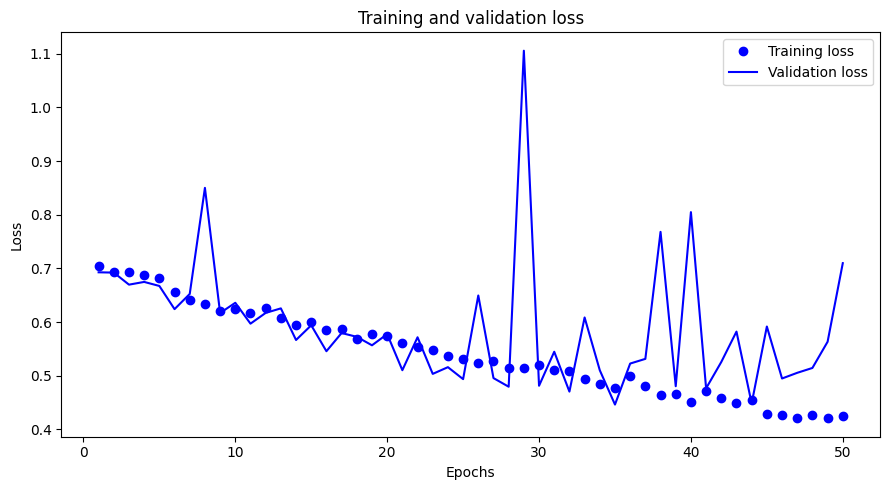

In [138]:
plot_training_val_loss(history)

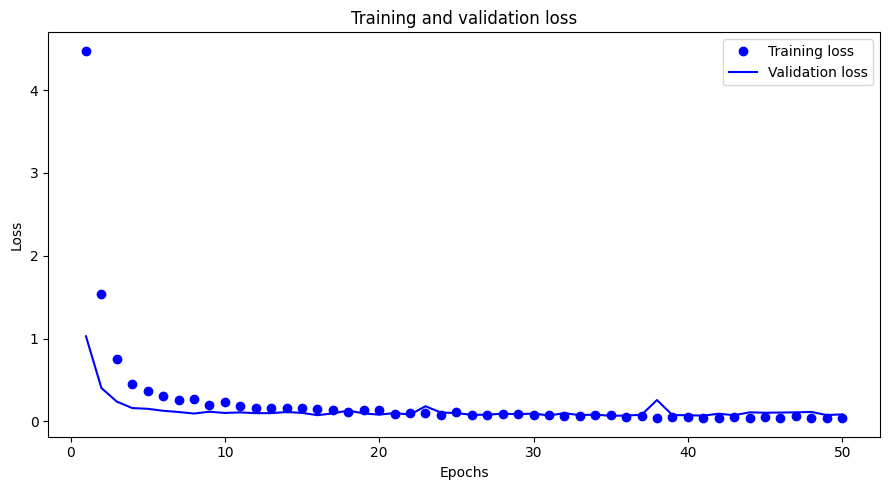

In [139]:
plot_training_val_loss(VGG16_model_history)

In [140]:
def plot_training_val_accuracy(model_history):
    history_dict = model_history.history
    plt.figure(figsize=(9, 5))
    acc_values = history_dict["accuracy"]
    val_acc_values = history_dict["val_accuracy"]
    epochs = range(1, len(acc_values) + 1)
    plt.plot(epochs, acc_values, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Training and validation accuracy")

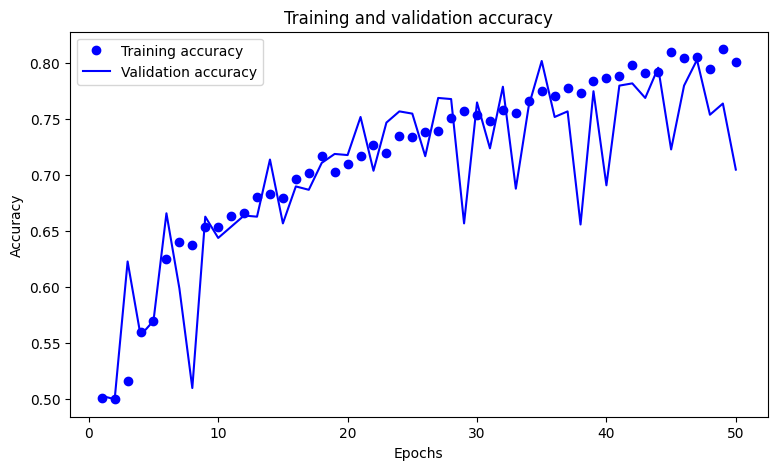

In [141]:
plot_training_val_accuracy(history)

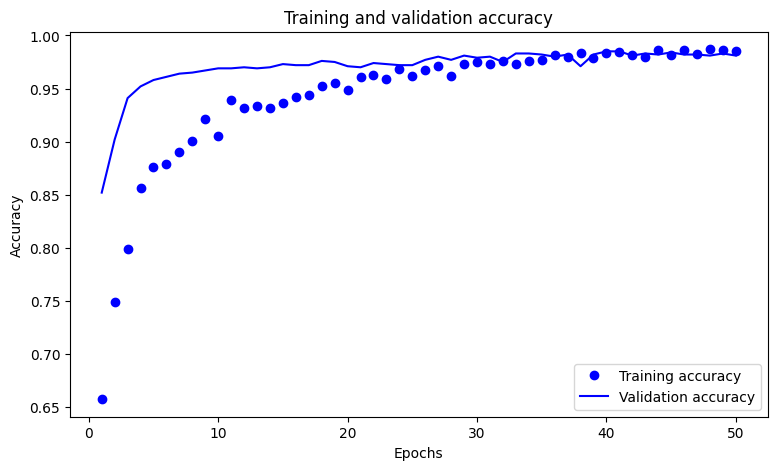

In [142]:
plot_training_val_accuracy(VGG16_model_history)